Install Kaggle, download dataset, import libraries

In [2]:
# !pip install -q kaggle

In [3]:
# !mkdir -p ~/.kaggle

In [4]:
#upload personal token of kaggle > profile > account
# from google.colab import files
# files.upload()

In [5]:
# !cp kaggle.json ~/.kaggle/

In [6]:
# !chmod 600 ~/.kaggle/kaggle.json

In [7]:
#!kaggle datasets download -d Username/Dataset name#
# !kaggle datasets download -d yinanliu99/liver-segmentation
# !kaggle datasets download -d andrewmvd/liver-tumor-segmentation

In [8]:
print("############# GPU #############")
!/opt/bin/nvidia-smi
print("############# PyTorch #############")
import torch
print(torch.__version__)
print("############# CPU #############")
!cat /proc/cpuinfo | grep model\ name
print("############# RAM #############")
!cat /proc/meminfo | grep MemTotal

############# GPU #############
Wed Sep 27 13:38:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                        

In [9]:
#start here (after transfer dataset to drive)
!unzip -q /content/drive/MyDrive/dataset/liver_tumor_segmentation/liver-tumor-segmentation.zip

In [23]:
!pip install -q monai
!pip install -q SimpleITK
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 667.8/667.8 kB 10.3 MB/s eta 0:00:00


In [42]:

import os
import glob
import monai
import torch
import numpy as np
from PIL import Image
from tqdm import tqdm
import SimpleITK as sitk
from statistics import mean
from torch.optim import Adam
from natsort import natsorted
import matplotlib.pyplot as plt
from transformers import SamModel
import matplotlib.patches as patches
from transformers import SamProcessor
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import threshold, normalize
# from SAM import SamPredictor, sam_model_registry, utils

%matplotlib inline

from monai.transforms import (
    EnsureChannelFirstd,
    EnsureTyped,
    Compose,
    CropForegroundd,
    CopyItemsd,
    LoadImaged,
    CenterSpatialCropd,
    Invertd,
    OneOf,
    Orientationd,
    MapTransform,
    NormalizeIntensityd,
    RandSpatialCropSamplesd,
    CenterSpatialCropd,
    RandSpatialCropd,
    SpatialPadd,
    ScaleIntensityRanged,
    Spacingd,
    RepeatChanneld,
    ToTensord,
)


Extract DICOM / Nii to single image/mask, store into corresponding folder

In [43]:
data = '/content/volume_pt1'
data_seg = '/content/segmentations'
images = sorted(
    glob.glob(os.path.join(data, "volume-[0-3].nii"))) #only take 4 samples
labels = sorted(
    glob.glob(os.path.join(data_seg, "segmentation-[0-3].nii"))) ##only take 4 samples

print('No. of images:', len(images), ' labels:', len(labels))

No. of images: 4  labels: 4


In [29]:

base_dir = '/content'
datasets = ['train', 'val', 'test']
data_types = ['2d_images', '2d_masks']

# Create directories
dir_paths = {}
for dataset in datasets:
    for data_type in data_types:
        dir_path = os.path.join(base_dir, f'{dataset}_{data_type}')
        dir_paths[f'{dataset}_{data_type}'] = dir_path
        os.makedirs(dir_path, exist_ok=True)

# Assuming first 2 patients for training, next 1 for validation and last 1 for testing
for idx, (img_path, mask_path) in enumerate(zip(images, labels)):
    ######################For DICOM series folder reader#########################
    # # Create a list of all the DICOM files in the directory
    # reader = sitk.ImageSeriesReader()
    # dicom_series = reader.GetGDCMSeriesFileNames(dicom_directory)
    # dicom_series.sort()
    # slice_index = 42
    # image = sitk.ReadImage(dicom_series[slice_index]) # Read the specific slice
    ##################################################################################

    # Load the 3D image and mask
    img = sitk.ReadImage(img_path)
    mask = sitk.ReadImage(mask_path)
    print("image: %s, mask: %s" %(img_path, mask_path))
    print('processing patient', idx, img.GetSize(), mask.GetSize())

    # Get the mask data as numpy array
    mask_data = sitk.GetArrayFromImage(mask)
    if idx < 2:  # Training
        img_dir = dir_paths['train_2d_images']
        mask_dir = dir_paths['train_2d_masks']
    elif idx == 2:  # Validation
        img_dir = dir_paths['val_2d_images']
        mask_dir = dir_paths['val_2d_masks']
    else:  # Testing
        img_dir = dir_paths['test_2d_images']
        mask_dir = dir_paths['test_2d_masks']

    print("Number of Slice: ", img.GetSize()[2])
    # note: GetSize, ReadImage return [x, y, slice], GetArrayFromImage return [slice, x, y]
    for i in range(img.GetSize()[2]):
      # If the mask slice is not empty, save the image and mask slices
      if np.any(mask_data[i, :, :]):
          img_slice = img[:, :, i]
          mask_slice = mask[:, :, i]
          # print(sitk.GetArrayFromImage(mask_slice).shape)
          img_slice_path = os.path.join(img_dir, f"{os.path.basename(img_path).replace('.nii', '')}_{i}.nii")
          mask_slice_path = os.path.join(mask_dir, f"{os.path.basename(mask_path).replace('.nii', '')}_{i}.nii")
          sitk.WriteImage(img_slice, img_slice_path)
          sitk.WriteImage(mask_slice, mask_slice_path)


image: /content/volume_pt1/volume-0.nii, mask: /content/segmentations/segmentation-0.nii
processing patient 0 (512, 512, 75) (512, 512, 75)
Number of Slice:  75
image: /content/volume_pt1/volume-1.nii, mask: /content/segmentations/segmentation-1.nii
processing patient 1 (512, 512, 123) (512, 512, 123)
Number of Slice:  123
image: /content/volume_pt1/volume-2.nii, mask: /content/segmentations/segmentation-2.nii
processing patient 2 (512, 512, 517) (512, 512, 517)
Number of Slice:  517
image: /content/volume_pt1/volume-3.nii, mask: /content/segmentations/segmentation-3.nii
processing patient 3 (512, 512, 534) (512, 512, 534)
Number of Slice:  534


img: /content/volume_pt1/volume-0.nii; mask: /content/segmentations/segmentation-0.nii


(-0.5, 511.5, 511.5, -0.5)

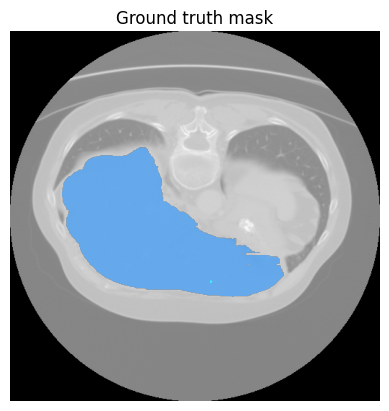

In [30]:
#display the image
def showMask(mask, ax, random_color=False):
  if random_color:
    color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
  else:
    color = np.array([30/255, 144/255, 255/255, 0.6])
  h, w = mask.shape[-2:]
  mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
  ax.imshow(mask_image)

img = sitk.ReadImage("/content/train_2d_images/volume-0_65.nii")
mask = sitk.ReadImage("/content/train_2d_masks/segmentation-0_65.nii")
print("img: %s; mask: %s" %(images[0], labels[0]))
mask_data = sitk.GetArrayFromImage(mask)
img_data = sitk.GetArrayFromImage(img)
fig, axes = plt.subplots()

axes.imshow(img_data, cmap='gray')
showMask(mask_data, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

In [31]:
data_paths = {}

for dataset in datasets:
    for data_type in data_types:
        dir_path = os.path.join(base_dir, f'{dataset}_{data_type}')
        files = sorted(glob.glob(os.path.join(dir_path, "*.nii")))
        data_paths[f'{dataset}_{data_type.split("_")[1]}'] = files

print('Number of training images', len(data_paths['train_images']))
print('Number of validation images', len(data_paths['val_images']))
print('Number of test images', len(data_paths['test_images']))
print(data_paths['train_images'])
print(data_paths['train_masks'])

Number of training images 58
Number of validation images 139
Number of test images 169
['/content/train_2d_images/volume-0_45.nii', '/content/train_2d_images/volume-0_46.nii', '/content/train_2d_images/volume-0_47.nii', '/content/train_2d_images/volume-0_48.nii', '/content/train_2d_images/volume-0_49.nii', '/content/train_2d_images/volume-0_50.nii', '/content/train_2d_images/volume-0_51.nii', '/content/train_2d_images/volume-0_52.nii', '/content/train_2d_images/volume-0_53.nii', '/content/train_2d_images/volume-0_54.nii', '/content/train_2d_images/volume-0_55.nii', '/content/train_2d_images/volume-0_56.nii', '/content/train_2d_images/volume-0_57.nii', '/content/train_2d_images/volume-0_58.nii', '/content/train_2d_images/volume-0_59.nii', '/content/train_2d_images/volume-0_60.nii', '/content/train_2d_images/volume-0_61.nii', '/content/train_2d_images/volume-0_62.nii', '/content/train_2d_images/volume-0_63.nii', '/content/train_2d_images/volume-0_64.nii', '/content/train_2d_images/volume

In [32]:
# create an instance of the processor for image preprocessing
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
print(processor)

SamProcessor:
- image_processor: SamImageProcessor {
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_pad": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "SamImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "pad_size": {
    "height": 1024,
    "width": 1024
  },
  "processor_class": "SamProcessor",
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "longest_edge": 1024
  }
}



In [33]:
def get_bounding_box(ground_truth_map):
    '''
    This function creates varying bounding box coordinates based on the segmentation contours as prompt for the SAM model
    The padding is random int values between 5 and 20 pixels
    If no contour is found, the bounding box will be set to the size of the image
    '''

    if len(np.unique(ground_truth_map)) > 1:

        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)

        # add perturbation to bounding box coordinates
        rand_pad_min = 5
        rand_pad_max = 10
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(rand_pad_min, rand_pad_max))
        x_max = min(W, x_max + np.random.randint(rand_pad_min, rand_pad_max))
        y_min = max(0, y_min - np.random.randint(rand_pad_min, rand_pad_max))
        y_max = min(H, y_max + np.random.randint(rand_pad_min, rand_pad_max))

        bbox = [x_min, y_min, x_max, y_max]

        return bbox
    else:
        # the image will be scaled to 256x256
        return [0, 0, 256, 256] # if there is no mask in the array, set bbox to image size

In [34]:
class SAMDataset(Dataset):
    def __init__(self, image_paths, mask_paths, processor):

        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.processor = processor
        self.transforms = transforms = Compose([

            # load .nii or .nii.gz files
            LoadImaged(keys=['img', 'label']),

            # add channel id to match PyTorch configurations
            EnsureChannelFirstd(keys=['img', 'label']),

            # reorient images for consistency and visualization
            # reorient the image to "PLI"
            Orientationd(keys=['img', 'label'], axcodes='PLI'),

            # resample all training images to a fixed spacing
            Spacingd(keys=['img', 'label'], pixdim=(1.5, 1.5), mode=("bilinear", "nearest")),

            # rescale image and label dimensions to 256x256
            CenterSpatialCropd(keys=['img', 'label'], roi_size=(256,256)),

            # scale intensities to 0 and 255 to match the expected input intensity range
            ScaleIntensityRanged(keys=['img'], a_min=-1000, a_max=2000,
                         b_min=0.0, b_max=255.0, clip=True),

            ScaleIntensityRanged(keys=['label'], a_min=0, a_max=255,
                         b_min=0, b_max=255, clip=True),

            SpatialPadd(keys=["img", "label"], spatial_size=(256,256))
#             RepeatChanneld(keys=['img'], repeats=3, allow_missing_keys=True)
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        # create a dict of images and labels to apply Monai's dictionary transforms
        data_dict = self.transforms({'img': image_path, 'label': mask_path})

        # squeeze extra dimensions
        image = data_dict['img'].squeeze()
        ground_truth_mask = data_dict['label'].squeeze()

        # convert to int type for huggingface's models expected inputs
        image = image.astype(np.uint8)

        # convert the grayscale array to RGB (3 channels)
        array_rgb = np.dstack((image, image, image))

        # convert to PIL image to match the expected input of processor
        image_rgb = Image.fromarray(array_rgb)

        # get bounding box prompt (returns xmin, ymin, xmax, ymax)
        # in this dataset, the contours are -1 so we change them to 1 for label and 0 for background
        ground_truth_mask[ground_truth_mask < 0] = 1

        prompt = get_bounding_box(ground_truth_mask)

        # prepare image and prompt for the model
        inputs = self.processor(image_rgb, input_boxes=[[prompt]], return_tensors="pt")

        # remove batch dimension which the processor adds by default
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}

        # add ground truth segmentation (ground truth image size is 256x256)
        inputs["ground_truth_mask"] = torch.from_numpy(ground_truth_mask.astype(np.int8))

        return inputs

In [35]:
# create train and validation dataloaders
train_dataset = SAMDataset(image_paths=data_paths['train_images'], mask_paths=data_paths['train_masks'], processor=processor)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

val_dataset = SAMDataset(image_paths=data_paths['val_images'], mask_paths=data_paths['val_masks'], processor=processor)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True)

/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


/usr/local/lib/python3.10/dist-packages/monai/transforms/spatial/array.py:639: UserWarning: axcodes ('PLI') length is smaller than number of input spatial dimensions D=2.
Orientation: spatial shape = (512, 512), channels = 1,please make sure the input is in the channel-first format.
  warnings.warn(


pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask torch.Size([256, 256])


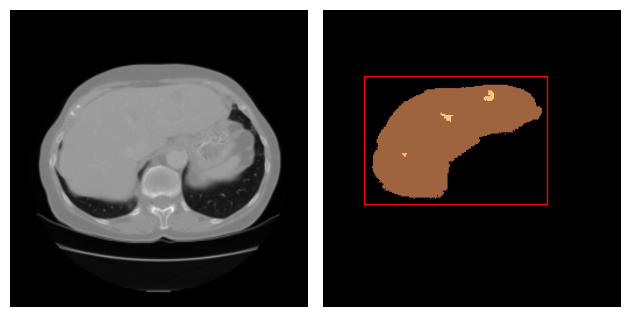

In [36]:
example = train_dataset[50]
for k,v in example.items():
    print(k,v.shape)

xmin, ymin, xmax, ymax = get_bounding_box(example['ground_truth_mask'])

fig, axs = plt.subplots(1, 2)

axs[0].imshow(example['pixel_values'][0], cmap='gray')
axs[0].axis('off')

axs[1].imshow(example['ground_truth_mask'], cmap='copper')

# create a Rectangle patch for the bounding box
rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')

# add the patch to the second Axes
axs[1].add_patch(rect)

axs[1].axis('off')

plt.tight_layout()
plt.show()

Training

In [37]:

# load the pretrained weights for finetuning
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder (encoder weights are frozen)
for name, param in model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
        print(name)
        param.requires_grad_(False)

vision_encoder.pos_embed
vision_encoder.patch_embed.projection.weight
vision_encoder.patch_embed.projection.bias
vision_encoder.layers.0.layer_norm1.weight
vision_encoder.layers.0.layer_norm1.bias
vision_encoder.layers.0.attn.rel_pos_h
vision_encoder.layers.0.attn.rel_pos_w
vision_encoder.layers.0.attn.qkv.weight
vision_encoder.layers.0.attn.qkv.bias
vision_encoder.layers.0.attn.proj.weight
vision_encoder.layers.0.attn.proj.bias
vision_encoder.layers.0.layer_norm2.weight
vision_encoder.layers.0.layer_norm2.bias
vision_encoder.layers.0.mlp.lin1.weight
vision_encoder.layers.0.mlp.lin1.bias
vision_encoder.layers.0.mlp.lin2.weight
vision_encoder.layers.0.mlp.lin2.bias
vision_encoder.layers.1.layer_norm1.weight
vision_encoder.layers.1.layer_norm1.bias
vision_encoder.layers.1.attn.rel_pos_h
vision_encoder.layers.1.attn.rel_pos_w
vision_encoder.layers.1.attn.qkv.weight
vision_encoder.layers.1.attn.qkv.bias
vision_encoder.layers.1.attn.proj.weight
vision_encoder.layers.1.attn.proj.bias
vision_

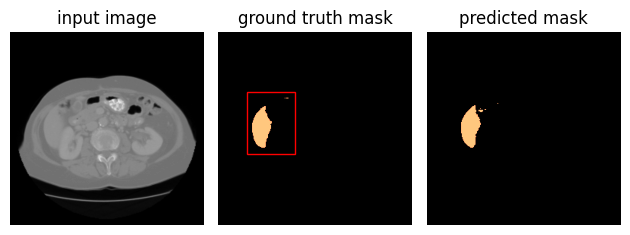

100%|██████████| 139/139 [01:17<00:00,  1.79it/s]


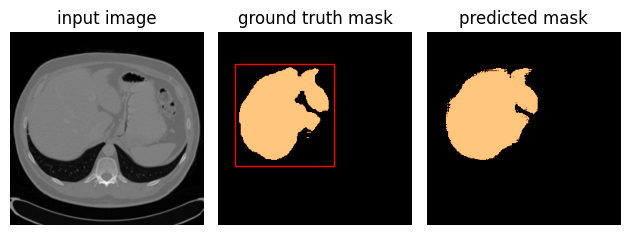

Model Was Not Saved!
EPOCH: 9
Mean loss: 0.06018000327307602


In [38]:
# define training loop
num_epochs = 10

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# define optimizer
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

# define segmentation loss with sigmoid activation applied to predictions from the model
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

# track mean train and validation losses
mean_train_losses, mean_val_losses = [], []

# create an artibarily large starting validation loss value
best_val_loss = 100.0
best_val_epoch = 0

# set model to train mode for gradient updating
model.train()
for epoch in range(num_epochs):

    # create temporary list to record training losses
    epoch_losses = []
    for i, batch in enumerate(tqdm(train_dataloader)):

        # forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

        # compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

        # backward pass (compute gradients of parameters w.r.t. loss)
        optimizer.zero_grad()
        loss.backward()

        # optimize
        optimizer.step()
        epoch_losses.append(loss.item())

        # visualize training predictions every 50 iterations
        if i % 50 == 0:

            # clear jupyter cell output
            clear_output(wait=True)

            fig, axs = plt.subplots(1, 3)
            xmin, ymin, xmax, ymax = get_bounding_box(batch['ground_truth_mask'][0])
            rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')

            axs[0].set_title('input image')
            axs[0].imshow(batch["pixel_values"][0,1], cmap='gray')
            axs[0].axis('off')

            axs[1].set_title('ground truth mask')
            axs[1].imshow(batch['ground_truth_mask'][0], cmap='copper')
            axs[1].add_patch(rect)
            axs[1].axis('off')

            # apply sigmoid
            medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))

            # convert soft mask to hard mask
            medsam_seg_prob = medsam_seg_prob.detach().cpu().numpy().squeeze()
            medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

            axs[2].set_title('predicted mask')
            axs[2].imshow(medsam_seg, cmap='copper')
            axs[2].axis('off')

            plt.tight_layout()
            plt.show()

    # create temporary list to record validation losses
    val_losses = []

    # set model to eval mode for validation
    with torch.no_grad():
        for val_batch in tqdm(val_dataloader):

            # forward pass
            outputs = model(pixel_values=val_batch["pixel_values"].to(device),
                      input_boxes=val_batch["input_boxes"].to(device),
                      multimask_output=False)

            # calculate val loss
            predicted_val_masks = outputs.pred_masks.squeeze(1)
            ground_truth_masks = batch["ground_truth_mask"].float().to(device)
            val_loss = seg_loss(predicted_val_masks, ground_truth_masks.unsqueeze(1))

            val_losses.append(val_loss.item())

        # visualize the last validation prediction
        fig, axs = plt.subplots(1, 3)
        xmin, ymin, xmax, ymax = get_bounding_box(val_batch['ground_truth_mask'][0])
        rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')

        axs[0].set_title('input image')
        axs[0].imshow(val_batch["pixel_values"][0,1], cmap='gray')
        axs[0].axis('off')

        axs[1].set_title('ground truth mask')
        axs[1].imshow(val_batch['ground_truth_mask'][0], cmap='copper')
        axs[1].add_patch(rect)
        axs[1].axis('off')

        # apply sigmoid
        medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))

        # convert soft mask to hard mask
        medsam_seg_prob = medsam_seg_prob.detach().cpu().numpy().squeeze()
        medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

        axs[2].set_title('predicted mask')
        axs[2].imshow(medsam_seg, cmap='copper')
        axs[2].axis('off')

        plt.tight_layout()
        plt.show()

        # save the best weights and record the best performing epoch
        if mean(val_losses) < best_val_loss:
            torch.save(model.state_dict(), f"best_weights.pth")
            print(f"Model Was Saved! Current Best val loss {best_val_loss}")
            best_val_loss = mean(val_losses)
            best_val_epoch = epoch
        else:
            print("Model Was Not Saved!")

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

    mean_train_losses.append(mean(epoch_losses))
    mean_val_losses.append(mean(val_losses))

Inference

In [39]:
# create test dataloader
test_dataset = SAMDataset(image_paths=data_paths['test_images'], mask_paths=data_paths['test_masks'], processor=processor)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [40]:

# Iteratire through test images
with torch.no_grad():
    for batch in tqdm(test_dataloader):

        # forward pass
        outputs = model(pixel_values=batch["pixel_values"].cuda(),
                      input_boxes=batch["input_boxes"].cuda(),
                      multimask_output=False)

        # compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().cuda()
#         loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))



        # apply sigmoid
        medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
        # convert soft mask to hard mask
        medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
        medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1)
        plt.imshow(batch["pixel_values"][0,1], cmap='gray')
        plt.axis('off')
        plt.subplot(1,3,2)
        plt.imshow(batch["ground_truth_mask"][0], cmap='copper')
        plt.axis('off')
        plt.subplot(1,3,3)
        plt.imshow(medsam_seg, cmap='copper')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    #     outputs = model(**inputs, multimask_output=False)

Output hidden; open in https://colab.research.google.com to view.

In [41]:
#save fine-tuned model
torch.save(model.state_dict(), '/content/drive/MyDrive/dataset/fine_tuned_sam.pth')